## Technical interview
By Joost van der Linden, February 11th, 2019.

### Part 3: Data prediction
Tasks covered: data transformation, visualization & machine learning.

In [1]:
# To auto-reload scripts from /src:
%load_ext autoreload
%autoreload 1

import os
import sys
src_dir = os.path.join(os.getcwd(), 'src')
sys.path.append(src_dir)
% aimport my_predict
import my_predict

In [2]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from xgboost import XGBClassifier

import matplotlib as mpl
import matplotlib.pyplot as plt 
%matplotlib inline

import seaborn as sns
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)}, font_scale=1.0)

data_dir = '../data'

In [3]:
columns_to_drop = [
    'education-num',              # cheating
    'education',                  # cheating
    'estimated-graduation-year'   # knowledge leak
]

df_train = (pd.read_pickle(data_dir + '/processed/adult-train-preprocessed.pickle')
              .drop(columns = columns_to_drop))
df_test  = (pd.read_pickle(data_dir + '/processed/adult-test-preprocessed.pickle')
              .drop(columns = columns_to_drop))

In [4]:
target_variable      = 'college-educated'
numeric_features     = [c for c in df_train if np.issubdtype(df_train[c].dtype, np.number)]
categorical_features = list(set(df_train.columns) - set(numeric_features + [target_variable]))

### 3.1 Feature preparation
#### 3.1.1 Categorical features
One-hot encoding

In [5]:
df_train = pd.get_dummies(df_train, columns = categorical_features)
df_test  = pd.get_dummies(df_test, columns = categorical_features)

#### 3.1.2 Numerical features
Standard scaling (center at zero, unit variance)

In [6]:
df_train[numeric_features] = StandardScaler().fit_transform(df_train[numeric_features].astype(float))
df_test[numeric_features]  = StandardScaler().fit_transform(df_test[numeric_features].astype(float))

#### 3.1.3 Target variable
Convert to integer

In [7]:
df_train[target_variable] = df_train[target_variable].astype(int)
df_test[target_variable]  = df_test[target_variable].astype(int)

#### 3.1.4 Feature name conversion
`xgboost` doesn't accept '<'

In [8]:
df_train.columns = df_train.columns.str.replace('_<=50K', '_leq50k')
df_test.columns  = df_test.columns.str.replace('_<=50K', '_leq50k')

### 3.2 Prediction
Model choice: `XGBClassifier` from `xgboost`
- Good performance out of the box
- Built-in feature selection
- Allows for mix of categorical and numeric features
- Provides feature importances
- Interface with `scikit-learn`

Risk: overfitting    
Mitigation: limit `max_depth`

In [9]:
features = list(set(df_train.columns) - set(['college-educated', 
                                             'native-country_Holand-Netherlands']))

In [10]:
clf = my_predict.analyze_model(df_train, df_test, 
                               features  = features, 
                               target    = 'college-educated',
                               estimator = XGBClassifier(max_depth = 10))

--- Validation set performance ---
Baseline accuracy: 

1    53.861508
0    46.138492
Name: college-educated, dtype: float64

Model accuracy:    73.68
AUC:               0.74

              precision    recall  f1-score   support

           0       0.71      0.72      0.72      3005
           1       0.76      0.75      0.75      3508

   micro avg       0.74      0.74      0.74      6513
   macro avg       0.74      0.74      0.74      6513
weighted avg       0.74      0.74      0.74      6513

--- Test set performance ---
Baseline accuracy: 

1    54.314846
0    45.685154
Name: college-educated, dtype: float64

Model accuracy:    72.86
AUC:               0.73

              precision    recall  f1-score   support

           0       0.70      0.72      0.71      7438
           1       0.76      0.74      0.75      8843

   micro avg       0.73      0.73      0.73     16281
   macro avg       0.73      0.73      0.73     16281
weighted avg       0.73      0.73      0.73     16281



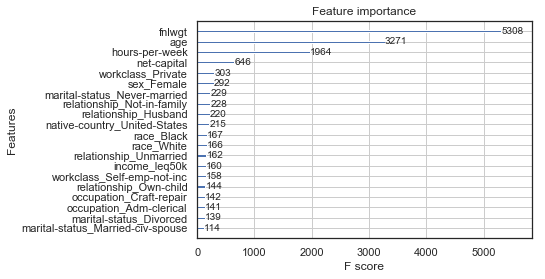

In [11]:
xgb.plot_importance(clf, max_num_features = 20);

- Remove `fnlwgt`? 
- `age` makes sense (partially cheating)
- `hours-per-week` is important, as expected
- `sex_Male` should be investigated further (bias?)

#### Other things to look at
- ROC curve
- Learning curves
- Parameter tuning